In [112]:
%matplotlib osx
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')

import swellEx_env
import loadSIO as sio

In [113]:
# Experimental data
dataFile = '/Users/edwardlrichards/Documents/data/SWellEx96/VLA_J132_0002'
sensorPosition = swellEx_env.loadArray(reducedIndex = False)

fS = 1500
tStart = 1000
snapLength = 4  # sec
sD = 54

In [114]:
loadIndex = [0,1,2]
experiment = sio.load_selection(dataFile, -1, 0, loadIndex,\
                channelNames = np.array(sensorPosition.values))
# experiment = sio.load_selection(dataFile, 1, 1e4, -1, channelNames = sensorPosition.values)
t = np.arange(experiment['data'].shape[0]) / fS
record = pd.DataFrame(experiment['data'], index = t,\
                      columns = experiment['channelName'][loadIndex])
record -= record.mean()

In [115]:
(record.shape[0] / fS) / 3600

0.5002427777777778

In [116]:
# Look at vertical intensity measurements for frequencies of interest
frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
# set up fft parameters
winLength = 2 ** (np.ceil(np.log2(snapLength * fS)))
NFFT = winLength * 2
kBeta = 7.85
window = np.kaiser(winLength, kBeta)
f = np.arange(winLength + 1) / NFFT  * fS

In [117]:
def windowedFFT(i):
    """Load snapshot indexed i"""
    index = np.arange((i - 1) * winLength, (i * winLength))
    data = np.array(record.iloc[index]) * window[:,None]
    data = np.fft.rfft(data, int(winLength * 2), axis = 0)
    data = pd.DataFrame(data, index = f, columns = record.columns)
    return data

In [118]:
data = windowedFFT(20)

for i, j in enumerate(data.columns):
    _ = plt.plot(data.index, 20 * np.log10(np.abs(data.iloc[:,i])),\
                 label = 'rd = %.1f m' %np.array(j))

for i in frequencies:
    _ = plt.plot((i, i), (-150, 10), 'k-', alpha=0.15)
_ = plt.title('Magnitude of measured pressure')
_ = plt.xlabel('frequency (hz)')
_ = plt.ylabel('magnitude (dB)')
_ = plt.xlim(30, 200)
_ = plt.ylim(-70, -10)
_ = plt.legend(loc=4)

In [119]:
dz = sensorPosition.iloc[1] - sensorPosition.iloc[0]
def caluclateI_z(snapshotData, diffType = 0):
    pressures = pd.concat([snapshotData.ix[f::1e6,:] for f in frequencies])
    p = pressures.mean(axis=1)
    
    if diffType == 1:
        diffCoefficents = np.array((-1, 0, 1))
        fac = 2
    elif diffType == 2:
        diffCoefficents = np.array((-3, 4, -1))
        fac = 2
    elif diffType == 3:
        diffCoefficents = np.array((-1, 1, 0))
        fac = 1
    elif diffType == 4:
        diffCoefficents = np.array((0, -1, 1))
        fac = 1

    v = diffCoefficents * pressures 
    v = v.sum(axis=1)
    coefficent = (1 /\
        (2 * dz * 1j * 2 * np.pi * np.array(frequencies) * 1e3))
    v = v * coefficent
    i_z = 1/2 * p.multiply(np.array(v).conj())
    i_z = pd.Series(i_z.real, index = i_z.index)
    return i_z

In [120]:
def caluclatePressure(snapshotData):
    pressures = pd.concat([snapshotData.ix[f::1e6,:] for f in frequencies])
    p = pressures.mean(axis=1)
    return p

In [121]:
numSamples = record.shape[0]

class getData:
    def __init__(self):
        self.i = 1
    def __iter__(self):
        self.i = 1
        return self
    def __next__(self):
        if self.i * window.size >= numSamples:
            raise StopIteration
        result = windowedFFT(self.i)
        self.i += 1
        return result

In [122]:
dataIter = getData()
vertIntensity = pd.concat([caluclateI_z(snap, diffType = 2)\
            for snap in dataIter], axis=1)
vertIntensity.columns = vertIntensity.columns * (winLength / fS)
vertIntensity2 = vertIntensity.T

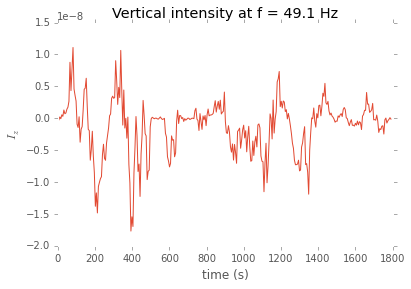

In [123]:
%matplotlib inline
index = 0
# _ = plt.plot(vertIntensity1.index, vertIntensity1.iloc[:, index])
_ = plt.plot(vertIntensity2.index, vertIntensity2.iloc[:, index])
# _ = plt.plot(vertIntensity2.index, vertIntensity3.iloc[:, index])
# _ = plt.plot(vertIntensity2.index, vertIntensity4.iloc[:, index])

_ = plt.xlabel('time (s)')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Vertical intensity at f = %.1f Hz'\
              %vertIntensity2.columns[index])

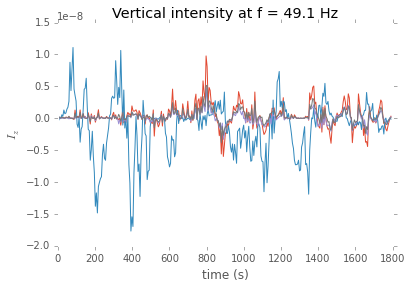

In [124]:
%matplotlib inline
index = 0
_ = plt.plot(vertIntensity1.index, vertIntensity1.iloc[:, index])
_ = plt.plot(vertIntensity2.index, vertIntensity2.iloc[:, index])
_ = plt.plot(vertIntensity2.index, vertIntensity3.iloc[:, index])
_ = plt.plot(vertIntensity2.index, vertIntensity4.iloc[:, index])

_ = plt.xlabel('time (s)')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Vertical intensity at f = %.1f Hz'\
              %vertIntensity2.columns[index])

In [125]:
plt.close()